# Airline Fare Price Prediction

Using the dataset provided by [lalit_joshi](https://www.kaggle.com/datasets/lalitjoshi89/airlinepriceprediction)

In [121]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import unicodedata

In [122]:
# Functio to print out the cross-validation scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [123]:
# Loading "raw" data from csv for a quick glance
data = pd.read_csv(r'dataset/airlines_data.csv')
data.info

<bound method DataFrame.info of      ;Airline_Name;Date_of_Journey;Source;Destination;Dept_Time;Total_Stops;Duration_of_Flight;Arr_Time;Fare
0     0;AirAsia;26/02/2022;Kolkata;Mumbai;13:30;1 st...                                                     
1     1;AirAsia;26/02/2022;Kolkata;Mumbai;9:05;2 sto...                                                     
2     2;AirAsia;26/02/2022;Kolkata;Mumbai;16:15;1 st...                                                     
3     3;AirAsia;26/02/2022;Kolkata;Mumbai;23:40;1 st...                                                     
4     4;AirAsia;26/02/2022;Kolkata;Mumbai;20:00;1 st...                                                     
...                                                 ...                                                     
2016  2019;Vistara;10/7/22;Mumbai;Chennai;6:20;2 Sto...                                                     
2017  2020;Vistara;10/7/22;Mumbai;Chennai;11:25;2 St...                                         

## DATA CLEANING

The data comes in a excel file format which I re-exported as a csv directly from Excel (note this could have been done using python too.)

In the data we have 10 variables and 2021 features. But we get all in 1 column due to the file being delimeted by semicolon. Lets fix that!

In [124]:
# Loading the data  with necessary attribute to convert it correctly into a dataframe
df = pd.read_csv(r'dataset/airlines_data.csv', delimiter=';', thousands=' ')
df

,Unnamed: 0,Airline_Name,Date_of_Journey,Source,Destination,Dept_Time,Total_Stops,Duration_of_Flight,Arr_Time,Fare
0,0,AirAsia,26/02/2022,Kolkata,Mumbai,13:30,1 stop,07 h 05 m,20:35,3 379
1,1,AirAsia,26/02/2022,Kolkata,Mumbai,9:05,2 stop,13 h 10 m,22:15,3 379
2,2,AirAsia,26/02/2022,Kolkata,Mumbai,16:15,1 stop,08 h 20 m,0:35,3 379
3,3,AirAsia,26/02/2022,Kolkata,Mumbai,23:40,1 stop,06 h 55 m,6:35,3 379
4,4,AirAsia,26/02/2022,Kolkata,Mumbai,20:00,1 stop,10 h 35 m,6:35,3 379
...,...,...,...,...,...,...,...,...,...,...
2016,2019,Vistara,10/7/22,Mumbai,Chennai,6:20,2 Stop,13h 55m,20:15,15 192
2017,2020,Vistara,10/7/22,Mumbai,Chennai,11:25,2 Stop,11h 20m,22:45,16 442
2018,2021,Vistara,10/7/22,Mumbai,Chennai,6:45,2 Stop,13h 30m,20:15,16 442
2019,2022,Vistara,10/7/22,Mumbai,Chennai,9:05,2 Stop,11h 10m,20:15,17 282


In [125]:
# Observing data types
df.dtypes

Unnamed: 0             int64
Airline_Name          object
Date_of_Journey       object
Source                object
Destination           object
Dept_Time             object
Total_Stops           object
Duration_of_Flight    object
Arr_Time              object
Fare                  object
dtype: object

In [126]:
# Checking for missing values
df.isnull().sum()

Unnamed: 0            0
Airline_Name          0
Date_of_Journey       0
Source                0
Destination           0
Dept_Time             0
Total_Stops           0
Duration_of_Flight    0
Arr_Time              0
Fare                  0
dtype: int64

### **Good!** and **Bad!**

Now there are some obvious observations that need to be address such as:

- The first `Unnamed` feature is redundant  and needs to be impute as it seems index.
- There is inconsistenacy on the date format on the `Date_of_Journey` feature
- The `Total_Stops` feature should be converted to numerical values.

A lot of our data is not the proper type such as:
- `Date_of_Journey` should be `datetime`
- `Total_Stops` should be `int`
- `Fare` should be `int`

It would be a good idea to change the name of the features to shorter names.

I found that `Airline_Name`, `Source` and `Destination` have repeated or diferent instances of the same word and that needs to be change i.e.: "Air Asia" instead of "AirAsia" or "MAA" instead of Chennai.

In [127]:
# Imputing the  "Unnamed" feature
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,Airline_Name,Date_of_Journey,Source,Destination,Dept_Time,Total_Stops,Duration_of_Flight,Arr_Time,Fare
0,AirAsia,26/02/2022,Kolkata,Mumbai,13:30,1 stop,07 h 05 m,20:35,3 379
1,AirAsia,26/02/2022,Kolkata,Mumbai,9:05,2 stop,13 h 10 m,22:15,3 379
2,AirAsia,26/02/2022,Kolkata,Mumbai,16:15,1 stop,08 h 20 m,0:35,3 379
3,AirAsia,26/02/2022,Kolkata,Mumbai,23:40,1 stop,06 h 55 m,6:35,3 379
4,AirAsia,26/02/2022,Kolkata,Mumbai,20:00,1 stop,10 h 35 m,6:35,3 379


In [128]:
# Renaming and reordering features.
new_cols = ["airline_name", "flight_date", "flight_dep", "flight_arr", "dep_time", "total_stops", "flight_time", "arr_time", "flight_fare"]
df.columns = new_cols

new_cols_ord = ["airline_name", "flight_date", "flight_dep", "dep_time", "flight_arr", "arr_time", "total_stops","flight_time", "flight_fare"]
df.reindex(columns=new_cols_ord)

df.head()

,airline_name,flight_date,flight_dep,flight_arr,dep_time,total_stops,flight_time,arr_time,flight_fare
0,AirAsia,26/02/2022,Kolkata,Mumbai,13:30,1 stop,07 h 05 m,20:35,3 379
1,AirAsia,26/02/2022,Kolkata,Mumbai,9:05,2 stop,13 h 10 m,22:15,3 379
2,AirAsia,26/02/2022,Kolkata,Mumbai,16:15,1 stop,08 h 20 m,0:35,3 379
3,AirAsia,26/02/2022,Kolkata,Mumbai,23:40,1 stop,06 h 55 m,6:35,3 379
4,AirAsia,26/02/2022,Kolkata,Mumbai,20:00,1 stop,10 h 35 m,6:35,3 379


In [129]:
# Changing data type of flight_date to desire format: Y-M-D.
df['flight_date'] = pd.to_datetime(df['flight_date'])

df.head()

,airline_name,flight_date,flight_dep,flight_arr,dep_time,total_stops,flight_time,arr_time,flight_fare
0,AirAsia,2022-02-26,Kolkata,Mumbai,13:30,1 stop,07 h 05 m,20:35,3 379
1,AirAsia,2022-02-26,Kolkata,Mumbai,9:05,2 stop,13 h 10 m,22:15,3 379
2,AirAsia,2022-02-26,Kolkata,Mumbai,16:15,1 stop,08 h 20 m,0:35,3 379
3,AirAsia,2022-02-26,Kolkata,Mumbai,23:40,1 stop,06 h 55 m,6:35,3 379
4,AirAsia,2022-02-26,Kolkata,Mumbai,20:00,1 stop,10 h 35 m,6:35,3 379


In [130]:
# Converting string to numerical values in total_flights feature.

"""numpy.where, is a vectorized version of if/else, with the 
condition constructed by str.contains"""

df['total_stops'] = np.where(df.total_stops.str.contains("1"), 1,
                    np.where(df.total_stops.str.contains("2"), 2, 
                    np.where(df.total_stops.str.contains("3"), 3, 0,
                    )
                )
            )

df.head()

,airline_name,flight_date,flight_dep,flight_arr,dep_time,total_stops,flight_time,arr_time,flight_fare
0,AirAsia,2022-02-26,Kolkata,Mumbai,13:30,1,07 h 05 m,20:35,3 379
1,AirAsia,2022-02-26,Kolkata,Mumbai,9:05,2,13 h 10 m,22:15,3 379
2,AirAsia,2022-02-26,Kolkata,Mumbai,16:15,1,08 h 20 m,0:35,3 379
3,AirAsia,2022-02-26,Kolkata,Mumbai,23:40,1,06 h 55 m,6:35,3 379
4,AirAsia,2022-02-26,Kolkata,Mumbai,20:00,1,10 h 35 m,6:35,3 379


In [131]:
# Changing "flight_fare" to int data type

"""The feature came with a unicode break '\xa0' the unicodedata.normalize() will remove this issue"""

df['flight_fare'] = df['flight_fare'].apply(lambda x: unicodedata.normalize("NFKD", x).replace(' ',''))
df['flight_fare'] = pd.to_numeric(df['flight_fare'])

df.head()

,airline_name,flight_date,flight_dep,flight_arr,dep_time,total_stops,flight_time,arr_time,flight_fare
0,AirAsia,2022-02-26,Kolkata,Mumbai,13:30,1,07 h 05 m,20:35,3379
1,AirAsia,2022-02-26,Kolkata,Mumbai,9:05,2,13 h 10 m,22:15,3379
2,AirAsia,2022-02-26,Kolkata,Mumbai,16:15,1,08 h 20 m,0:35,3379
3,AirAsia,2022-02-26,Kolkata,Mumbai,23:40,1,06 h 55 m,6:35,3379
4,AirAsia,2022-02-26,Kolkata,Mumbai,20:00,1,10 h 35 m,6:35,3379


In [132]:
# Removing repeated values on 'airline_name' feature
airline_values = {
    'Air Asia':'AirAsia',
    'Spicejet':'SpiceJet'
}

for key, value in airline_values.items():
    # Replace key character with value character in string
    df['airline_name'] = df['airline_name'].replace(key, value)

In [133]:
# Removing repeated values on 'flight_dep' feature
dest_values = {'DEL':'New Delhi', 'GAU': 'Guwahati',
                'MAA': 'Chennai', 'BLR':'Bangalore',
                'CCU':'Kolkata', 'BOM':'Mumbai',
                'Bengaluru':'Bangalore'}

for key, value in dest_values.items():
    # Replace key character with value character in string
    df['flight_dep'] = df['flight_dep'].replace(key, value)

In [134]:
# Removing repeated values on 'flight_arr' feature
for key, value in dest_values.items():
    # Replace key character with value character in string
    df['flight_arr'] = df['flight_arr'].replace(key, value)

df.head()

,airline_name,flight_date,flight_dep,flight_arr,dep_time,total_stops,flight_time,arr_time,flight_fare
0,AirAsia,2022-02-26,Kolkata,Mumbai,13:30,1,07 h 05 m,20:35,3379
1,AirAsia,2022-02-26,Kolkata,Mumbai,9:05,2,13 h 10 m,22:15,3379
2,AirAsia,2022-02-26,Kolkata,Mumbai,16:15,1,08 h 20 m,0:35,3379
3,AirAsia,2022-02-26,Kolkata,Mumbai,23:40,1,06 h 55 m,6:35,3379
4,AirAsia,2022-02-26,Kolkata,Mumbai,20:00,1,10 h 35 m,6:35,3379


In [135]:
# Creating a new feature with only the flight day
df['flight_day'] = pd.to_datetime(df.flight_date, format = "%Y-%m-%d").dt.day

In [136]:
# Creating a new feature with only the flight month
df['flight_month'] = pd.to_datetime(df.flight_date, format = "%Y-%m-%d").dt.month

In [137]:
# After the flight date has been use to create to new feature (flight_day, flight_month) we can drop it
df.drop(['flight_date'], axis = 1, inplace = True)
df.head()

,airline_name,flight_dep,flight_arr,dep_time,total_stops,flight_time,arr_time,flight_fare,flight_day,flight_month
0,AirAsia,Kolkata,Mumbai,13:30,1,07 h 05 m,20:35,3379,26,2
1,AirAsia,Kolkata,Mumbai,9:05,2,13 h 10 m,22:15,3379,26,2
2,AirAsia,Kolkata,Mumbai,16:15,1,08 h 20 m,0:35,3379,26,2
3,AirAsia,Kolkata,Mumbai,23:40,1,06 h 55 m,6:35,3379,26,2
4,AirAsia,Kolkata,Mumbai,20:00,1,10 h 35 m,6:35,3379,26,2


In [138]:
# Extracting the values from dep_time into new features

# Extracting the hours from the departure time
df['dep_hour'] = pd.to_datetime(df['dep_time']).dt.hour

# Extracting the minutes from the departure time
df['dep_min'] = pd.to_datetime(df['dep_time']).dt.minute

# Droping the dep_time feature
df.drop(['dep_time'], axis = 1, inplace = True)

In [139]:
# Same as with departure time now extracting the values from arr_time into new features

# Extracting the hours from the arrival time
df['arr_hour'] = pd.to_datetime(df['arr_time']).dt.hour

# Extracting the minutes from the arrival time
df['arr_min'] = pd.to_datetime(df['arr_time']).dt.minute

# Droping the flight_dep feature
df.drop(['arr_time'], axis = 1, inplace = True)
df.head()

,airline_name,flight_dep,flight_arr,total_stops,flight_time,flight_fare,flight_day,flight_month,dep_hour,dep_min,arr_hour,arr_min
0,AirAsia,Kolkata,Mumbai,1,07 h 05 m,3379,26,2,13,30,20,35
1,AirAsia,Kolkata,Mumbai,2,13 h 10 m,3379,26,2,9,5,22,15
2,AirAsia,Kolkata,Mumbai,1,08 h 20 m,3379,26,2,16,15,0,35
3,AirAsia,Kolkata,Mumbai,1,06 h 55 m,3379,26,2,23,40,6,35
4,AirAsia,Kolkata,Mumbai,1,10 h 35 m,3379,26,2,20,0,6,35


In [140]:
# Extracting the flight time into hours and minutes from the flight_time feature

# Assigning and converting flight_time into a list
flight_time = list(df['flight_time'])

for i in range(len(flight_time)):
    if len(flight_time[i].split()) != 4: # Check if flight_time contains only hour or mins
        if 'h' in flight_time[i]:
            flight_time[i] = flight_time[i].strip() + ' 0m' # Adds 0 minute
        else:
            flight_time[i] = '0h ' + flight_time[i] # Adds 0 hours

# Adding the hours and minutes to separate list to later convert into new features
flight_time_hrs = []
flight_time_mins = []

for i in range(len(flight_time)):
    flight_time_hrs.append(int(flight_time[i].split(sep = 'h')[0])) # Extracts the hours from flight_time
    flight_time_mins.append(int(flight_time[i].split(sep = 'm')[0].split()[-1])) # Extracts only minutes from flight_time


In [141]:
# Creating new features for every flight time hour and minute
df['flight_time_hrs'] = flight_time_hrs
df['flight_time_mins'] = flight_time_mins

# Droping the flight_time feature after the the new features have been created
df.drop(['flight_time'], axis = 1, inplace = True)
df.head()

,airline_name,flight_dep,flight_arr,total_stops,flight_fare,flight_day,flight_month,dep_hour,dep_min,arr_hour,arr_min,flight_time_hrs,flight_time_mins
0,AirAsia,Kolkata,Mumbai,1,3379,26,2,13,30,20,35,7,5
1,AirAsia,Kolkata,Mumbai,2,3379,26,2,9,5,22,15,13,10
2,AirAsia,Kolkata,Mumbai,1,3379,26,2,16,15,0,35,8,20
3,AirAsia,Kolkata,Mumbai,1,3379,26,2,23,40,6,35,6,55
4,AirAsia,Kolkata,Mumbai,1,3379,26,2,20,0,6,35,10,35


In [142]:
# Converting "airline_name" from categorical data to numerical

airline = df[['airline_name']]

airline = pd.get_dummies(airline, drop_first=True)

airline.head()

,airline_name_AirAsia,airline_name_Go First,airline_name_IndiGo,airline_name_SpiceJet,airline_name_Vistara
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


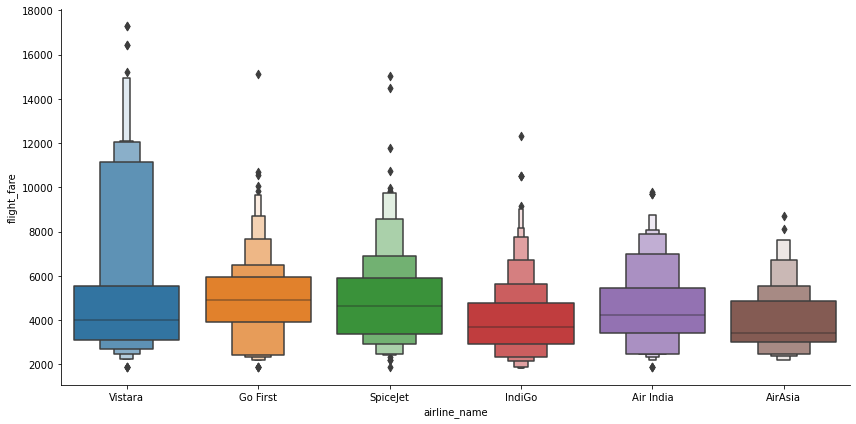

In [143]:
# Airline vs Price
sns.catplot(y = 'flight_fare', x = 'airline_name', data = df.sort_values("flight_fare", ascending = False), kind='boxen', height = 6, aspect = 2)
plt.show()

In [144]:
# Looking into flight_dep data
df['flight_dep'].value_counts()

New Delhi    736
Kolkata      467
Mumbai       356
Bangalore    336
Chennai       86
Guwahati      40
Name: flight_dep, dtype: int64

In [145]:
# Converting "flight_dep" from categorical data to numerical

origin = df[['flight_dep']]

origin = pd.get_dummies(origin, drop_first=True)

origin.head()

,flight_dep_Chennai,flight_dep_Guwahati,flight_dep_Kolkata,flight_dep_Mumbai,flight_dep_New Delhi
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0


In [146]:
# Looking into flight_dep data
df['flight_arr'].value_counts()

Mumbai       655
New Delhi    582
Bangalore    314
Chennai      240
Kolkata      197
Guwahati      33
Name: flight_arr, dtype: int64

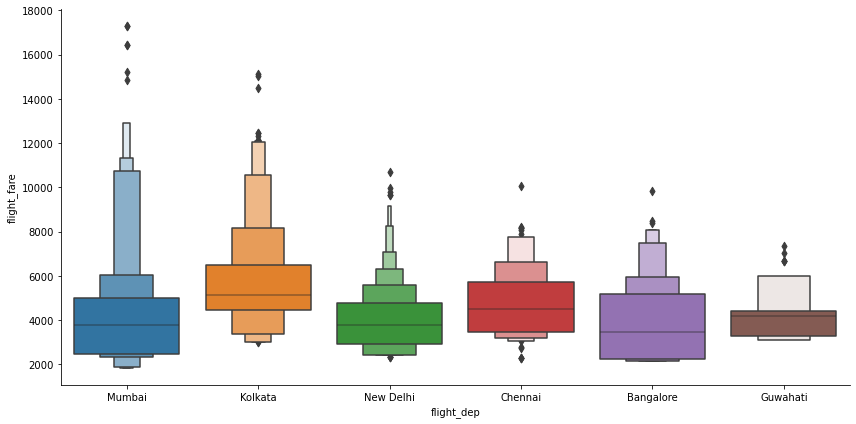

In [147]:
# Flight Departure vs Flight Fare

sns.catplot(y="flight_fare", x="flight_dep", data=df.sort_values("flight_fare", ascending=False), kind='boxen', height= 6, aspect=2)
plt.show()

In [148]:
# Converting "flight_arr" from categorical data to numerical

destination = df[['flight_arr']]

destination = pd.get_dummies(destination, drop_first=True)

destination.head()

,flight_arr_Chennai,flight_arr_Guwahati,flight_arr_Kolkata,flight_arr_Mumbai,flight_arr_New Delhi
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [149]:
# Concatenating all dataframes --> data + airline + origin + destiantion
full_data = pd.concat([df, airline, origin, destination], axis = 1)

# Dropping airline_name, flight_dep and flight_arr features
full_data.drop(["airline_name", "flight_dep", "flight_arr"], axis = 1, inplace = True)
full_data.head()

,total_stops,flight_fare,flight_day,flight_month,dep_hour,dep_min,arr_hour,arr_min,flight_time_hrs,flight_time_mins,...,flight_dep_Chennai,flight_dep_Guwahati,flight_dep_Kolkata,flight_dep_Mumbai,flight_dep_New Delhi,flight_arr_Chennai,flight_arr_Guwahati,flight_arr_Kolkata,flight_arr_Mumbai,flight_arr_New Delhi
0,1,3379,26,2,13,30,20,35,7,5,...,0,0,1,0,0,0,0,0,1,0
1,2,3379,26,2,9,5,22,15,13,10,...,0,0,1,0,0,0,0,0,1,0
2,1,3379,26,2,16,15,0,35,8,20,...,0,0,1,0,0,0,0,0,1,0
3,1,3379,26,2,23,40,6,35,6,55,...,0,0,1,0,0,0,0,0,1,0
4,1,3379,26,2,20,0,6,35,10,35,...,0,0,1,0,0,0,0,0,1,0


In [150]:
# Checking the amount of rows and columns in the dataframe
full_data.shape, 

((2021, 25),)

## Exploratory Data Analaysis

- Highest and lowest fare (More expensive or cheapest airline to flight with)
- Longest and shortest flight
- Cheapest

In [151]:
# Selecting features to check correlations
full_data.iloc[: , :10]

,total_stops,flight_fare,flight_day,flight_month,dep_hour,dep_min,arr_hour,arr_min,flight_time_hrs,flight_time_mins
0,1,3379,26,2,13,30,20,35,7,5
1,2,3379,26,2,9,5,22,15,13,10
2,1,3379,26,2,16,15,0,35,8,20
3,1,3379,26,2,23,40,6,35,6,55
4,1,3379,26,2,20,0,6,35,10,35
...,...,...,...,...,...,...,...,...,...,...
2016,2,15192,7,10,6,20,20,15,13,55
2017,2,16442,7,10,11,25,22,45,11,20
2018,2,16442,7,10,6,45,20,15,13,30
2019,2,17282,7,10,9,5,20,15,11,10


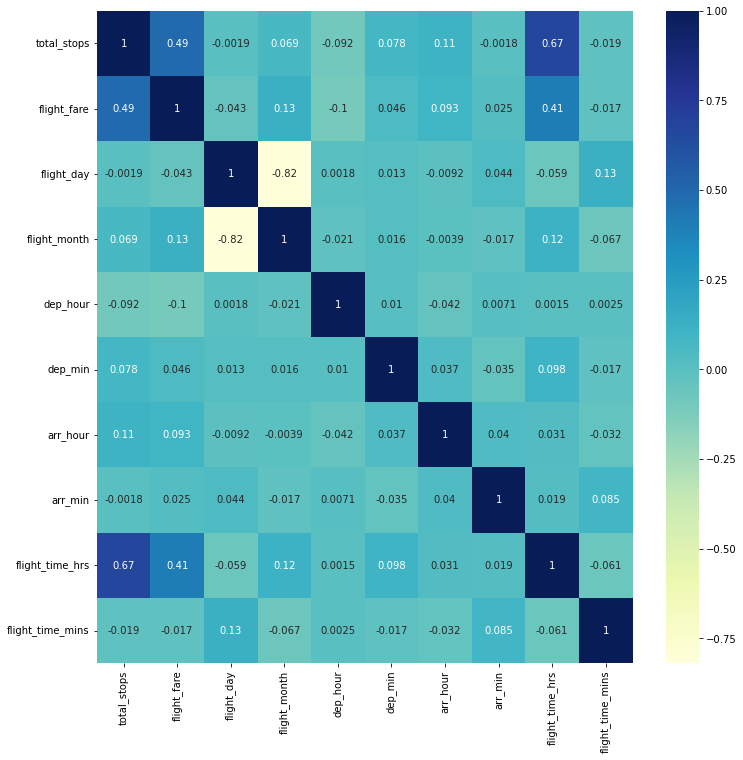

In [152]:
# Plotting the correlation between features
plt.figure(figsize = (12, 12))
sns.heatmap(full_data.iloc[: , :10].corr(), annot=True, cmap="YlGnBu")
plt.show()

Depandable feature to check which airline is the pick to fly with

- flight time hr / min
- fare
- flight date day / month
- total stops

found that the dependable are all variables but the one to predict

min 1841

4511.82

max 17282

0 - 1841
1841 -

In [153]:
# Creating a fare category feature and categorized the price in bins
# the numbers go from zero to 17282
full_data['fare_cat'] = pd.cut(full_data['flight_fare'], bins=[0, 2073.431268, 4146.862536, 6220.293803999999, 8293.725072,
10367.15634, 12440.587608, 14514.018876, 16587.450144, 17282., np.inf], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

<AxesSubplot:>

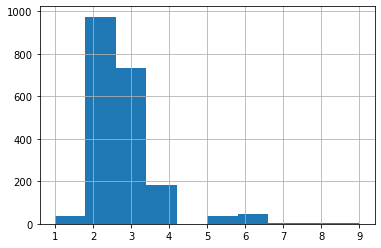

In [154]:
# Histogram of the fare categories
full_data['fare_cat'].hist()

In [155]:
# Splitting data in train and test
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ids, test_ids in split.split(full_data, full_data['fare_cat']):
    train_data = full_data.loc[train_ids]
    test_data = full_data.loc[test_ids]

In [156]:
# Checking the outcome of sampling bias
test_data['fare_cat'].value_counts() / len(test_data)

2     0.481481
3     0.362963
4     0.091358
6     0.022222
5     0.019753
1     0.017284
7     0.002469
8     0.002469
9     0.000000
10    0.000000
Name: fare_cat, dtype: float64

In [157]:
train_data['fare_cat'].value_counts() / len(train_data)


2     0.482054
3     0.363243
4     0.089728
6     0.022896
5     0.019183
1     0.017327
8     0.003094
7     0.001238
9     0.001238
10    0.000000
Name: fare_cat, dtype: float64

In [158]:
# Removing the 'fare_cat' feature to return data to its original state
for set_ in (train_data, test_data):
    set_.drop('fare_cat', axis = 1, inplace=True)

### Looking of Correlations

Since the dataset is not too large, is easy to compute the standard correlation coefficient (also called `Pearson's r`) between every pair of features.

In [159]:
# Computing the standard correlation coefficient
corr_matrix = train_data.corr()

In [160]:
# Looking at how each attribute correlate with the meadian flight price
corr_matrix["flight_fare"].sort_values(ascending=False)

flight_fare              1.000000
total_stops              0.502420
flight_time_hrs          0.412407
flight_dep_Kolkata       0.316996
airline_name_Vistara     0.161900
flight_month             0.140007
flight_arr_New Delhi     0.125764
arr_hour                 0.106778
flight_arr_Chennai       0.083268
airline_name_SpiceJet    0.081840
airline_name_Go First    0.081318
dep_min                  0.060252
flight_dep_Chennai       0.025408
arr_min                  0.024676
flight_dep_Guwahati      0.002774
flight_time_mins        -0.012023
flight_dep_Mumbai       -0.029126
flight_arr_Guwahati     -0.040412
flight_arr_Kolkata      -0.050687
flight_day              -0.053649
airline_name_AirAsia    -0.077919
dep_hour                -0.104091
flight_arr_Mumbai       -0.163331
flight_dep_New Delhi    -0.175525
airline_name_IndiGo     -0.204824
Name: flight_fare, dtype: float64

array([[<AxesSubplot:xlabel='flight_fare', ylabel='flight_fare'>,
        <AxesSubplot:xlabel='total_stops', ylabel='flight_fare'>,
        <AxesSubplot:xlabel='flight_time_hrs', ylabel='flight_fare'>,
        <AxesSubplot:xlabel='flight_month', ylabel='flight_fare'>],
       [<AxesSubplot:xlabel='flight_fare', ylabel='total_stops'>,
        <AxesSubplot:xlabel='total_stops', ylabel='total_stops'>,
        <AxesSubplot:xlabel='flight_time_hrs', ylabel='total_stops'>,
        <AxesSubplot:xlabel='flight_month', ylabel='total_stops'>],
       [<AxesSubplot:xlabel='flight_fare', ylabel='flight_time_hrs'>,
        <AxesSubplot:xlabel='total_stops', ylabel='flight_time_hrs'>,
        <AxesSubplot:xlabel='flight_time_hrs', ylabel='flight_time_hrs'>,
        <AxesSubplot:xlabel='flight_month', ylabel='flight_time_hrs'>],
       [<AxesSubplot:xlabel='flight_fare', ylabel='flight_month'>,
        <AxesSubplot:xlabel='total_stops', ylabel='flight_month'>,
        <AxesSubplot:xlabel='flight_time

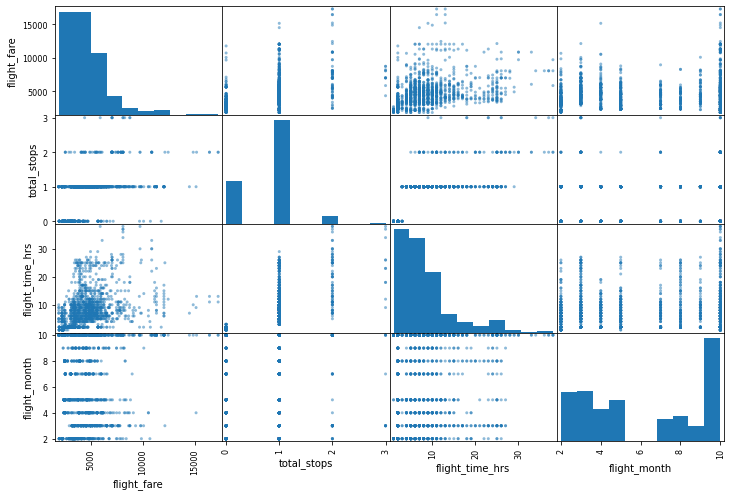

In [161]:
# scatter matrix
from pandas.plotting import scatter_matrix

atributes = ['flight_fare', 'total_stops', 'flight_time_hrs', 'flight_month']
scatter_matrix(train_data[atributes], figsize=(12, 8))

<AxesSubplot:xlabel='flight_time_hrs', ylabel='flight_fare'>

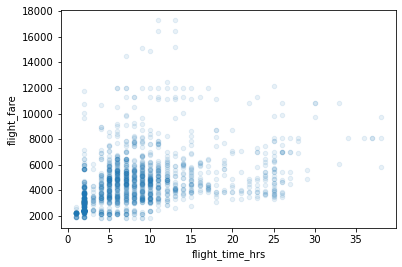

In [162]:
# Checking on the most correlated atributes
train_data.plot(kind='scatter', x='flight_time_hrs', y='flight_fare', alpha=0.1)

In this chart we can see that there are many outliers in the flight hours and this is due to the fact that in the dataset the "flight time" has the stop time include. Regardless of that we can see the strog correlation in flights from 1 to 10 hours.

## Data for Machine Learning Algorithms

In [163]:
# Separating predictors and label before applying transformations
X_train = train_data.drop('flight_fare', axis=1)
y_train = train_data['flight_fare'].copy()

X_test = test_data.drop('flight_fare', axis=1)
y_test = test_data['flight_fare'].copy()

## Lineal Regression

In [164]:
# Lineal Regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [166]:
# Measuring Lineal Regression RMSE (Root Mean Square Error)
from sklearn.metrics import mean_squared_error
y_pred = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1502.3504892351666

## Decission Tree Regressor

In [167]:
# Training a Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [168]:
#Measuring the Decison tree Regressor RMSE
y_pred = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, y_pred)
tree_rmse = np.sqrt(tree_mse)
tree_mse

0.0

## Cross-Validation

In [169]:
# Using K-fold cross-validation for Decision Tree Regressor
from sklearn.model_selection import cross_val_score
tree_scores = cross_val_score(tree_reg, X_train, y_train,
    scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

# Looking at the Descision Tree results
display_scores(tree_rmse_scores)

Scores: [1533.22677971 1437.98923827 1478.33561318 1740.88501155 1548.06645031
 1157.80125269 1416.29804825 1486.03677759 1435.66605834 1358.09143345]
Mean: 1459.239666334673
Standard deviation: 140.61240763960626


In [170]:
# Using K-fold cross-validation for Lineal Regression
lin_scores = cross_val_score(lin_reg, X_train, y_train,
    scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

# Looking at the Lineal Regression results after cross-validation
display_scores(lin_rmse_scores)

Scores: [1680.09539426 1559.31795945 1378.96513065 1533.4575362  1586.38839394
 1531.72594427 1371.62761466 1578.27437918 1607.45235289 1404.41339322]
Mean: 1523.1718098735923
Standard deviation: 99.05106530558452


## Random Forest Regressor

In [171]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [172]:
#Measuring the Random Forest Regressor RMSE
y_pred = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, y_pred)
forest_rmse = np.sqrt(forest_mse)
forest_mse

159603.43248273517

In [173]:
# Using K-fold cross-validation for Random Forest Regressor
forest_scores = cross_val_score(forest_reg, X_train, y_train,
    scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

# Looking at the Random Forest Regressor results after cross-validation
display_scores(forest_rmse_scores)

Scores: [1090.91422434 1187.09105039 1064.63475538 1080.63373784 1053.15963497
  869.96421459  902.99111703 1238.96238702 1066.92480368  969.73636856]
Mean: 1052.5012293785614
Standard deviation: 108.64066114297083


In [ ]:
# Unique values check cell
unique_vals = df['airline_name'].unique()
print(f"There are {len(unique_vals)} unique elements in this feature : {unique_vals} ")